In [2]:
## good for development
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Do the wavelet transform of the maps

In [20]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

import gmca4im_lib2 as g4i


In [5]:
file = h5py.File('../sim_10MHz.hd5','r')

In [6]:
file.keys()

<KeysViewHDF5 ['cosmological_signal', 'frequencies', 'gal_ff', 'gal_synch', 'noise', 'point_sources', 'pol_leakage']>

In [7]:
components = ['cosmological_signal', 'gal_ff', 'gal_synch', 'noise', 'point_sources', 'pol_leakage']

In [8]:
nu_ch = np.array(file['frequencies'])

In [10]:
len(nu_ch)

40

Preparing the observed map (sum of all components + noise):

In [11]:
npix = np.shape(file['cosmological_signal'])[1]
obs_maps = np.zeros((len(nu_ch),npix))

for c in components:
    print(c)
    tmp_component = np.array(file[c])
    obs_maps += tmp_component
    del tmp_component
    
## remove mean
obs_maps = np.array([[obs_maps[i] - np.mean(obs_maps[i],axis=0)] for i in range(len(nu_ch))])
obs_maps = obs_maps[:,0,:]

cosmological_signal
gal_ff
gal_synch
noise
point_sources
pol_leakage


Running the wavelet transform of maps:

In [13]:
## wavelet transform it
X_wt = g4i.wavelet_transform(obs_maps)


Wavelet transforming the data . . .
. . completed in 5.32 minutes



In [17]:
X_wt.shape

(40, 2359296)

#### Let's have a look at the eigenvalues

In [22]:
## function for extracting eigenvalues
def EVN(X):
    C_ij = np.cov(X) #Obtain frequency covariance matrix for input data
    # Get the eigenvalues and eigenvectors of covariance matrix:
    eigenval, eigenvec = np.linalg.eigh(C_ij)
    eigenval = eigenval[::-1] # largest eigenvals first
    del eigenvec

    return eigenval

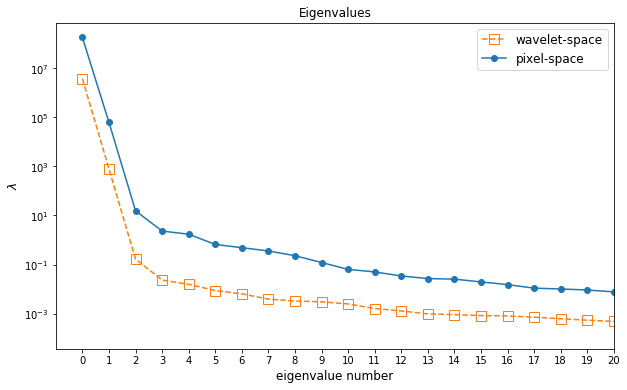

In [57]:
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["axes.labelsize"] = 12

plt.semilogy(EVN(X_wt),'--s',c='#ff7f0e',mfc='none',markersize=10,label='wavelet-space')
plt.semilogy(EVN(obs_maps),'-o',c='#1f77b4',markersize=6,label='pixel-space')

plt.legend(fontsize=12)
x_ticks = np.arange(25)
ax = plt.gca()
ax.set(xlim=[-1,20],xticks=x_ticks,xlabel="eigenvalue number",ylabel="$\\lambda$",title='Eigenvalues');



# Let's run GMCA

In [61]:
################   GMCA PARAMETERS   ##################
n_s   = 3   # number of sources to be estimated
mints = 0.1 # min threshold
nmax  = 100 # number of iterations
L0    = 0   # switch between L0 norm (1) or L1 norm (0)
#######################################################

# initial guess for the mixing matrix?
# i.e. we could start from PCA-determined mix matrix
AInit = None

# we can impose a column of the mixing matrix
ColFixed = None

# we can whiten the data
whitening = False; epsi = 1e-3

# estimated mixing matrix:
Ae = g4i.run_GMCA(X_wt,AInit,n_s,mints,nmax,L0,ColFixed,whitening,epsi)


Now running GMCA . . .
. . completed in 3.11 minutes



#### Let's have a look at the column of the mixing matrix

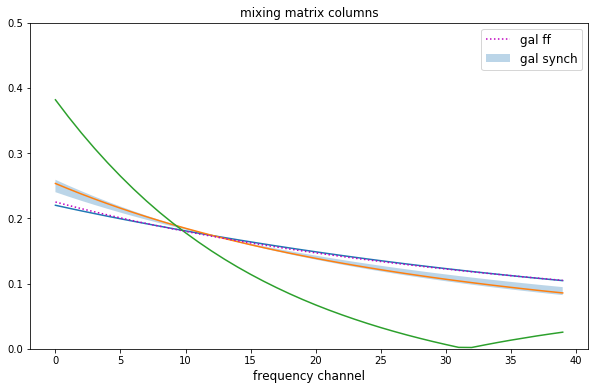

In [91]:
# gal freefree spectral index for reference
FF_col = np.array([nu_ch**(-2.13)]).T 

# gal synchrotron spectral index region for referencex = np.arange(0,len(nu_ch))
sync_A = np.array([nu_ch**(-3.2)]).T; y1 = sync_A/np.linalg.norm(sync_A)
sync_B = np.array([nu_ch**(-2.6)]).T; y2 = sync_B/np.linalg.norm(sync_B)

### actual plotting
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["axes.labelsize"] = 12

x = np.arange(0,len(nu_ch))

plt.fill_between(x,y1.T[0],y2.T[0],alpha=0.3,label='gal synch')
plt.plot(abs(Ae/np.linalg.norm(Ae,axis=0)))
plt.plot(FF_col/np.linalg.norm(FF_col),'m:',label='gal ff')

ax = plt.gca()
ax.set(ylim=[0.0,0.5],xlabel="frequency channel",title='mixing matrix columns');
plt.legend(fontsize=12)

In [81]:
y1.T[0]

array([0.25910973, 0.25015643, 0.24160484, 0.23343287, 0.22561989,
       0.21814657, 0.21099481, 0.20414766, 0.19758921, 0.19130456,
       0.18527967, 0.1795014 , 0.17395736, 0.16863591, 0.16352609,
       0.15861757, 0.15390064, 0.14936611, 0.14500534, 0.14081016,
       0.13677284, 0.13288611, 0.12914307, 0.12553719, 0.12206232,
       0.1187126 , 0.11548251, 0.1123668 , 0.10936049, 0.10645888,
       0.10365747, 0.10095204, 0.09833852, 0.0958131 , 0.09337213,
       0.09101212, 0.0887298 , 0.08652201, 0.08438576, 0.08231821])